# Random Forest (Ensemble Model)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2021-12-29 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', select_feature = True, start_date = '2021-12-29'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

    if select_feature:
        selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
        basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']
        X = X[selected_features + basic_features]

    return X, y

In [3]:
# Data with full set of technical features
X_pandas, y = prepare_dataset(select_feature=False)
X = np.array(X_pandas)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


**Train/Test Data Split and Data Normalization**

In [4]:
# Convert data to float32 for PyTorch
X = X.astype(np.float32)

# Split training and validation data
split = int(0.8 * len(X))
X_train = X[:split]
X_valid = X[split:]

y_train = y[:split]
y_valid = y[split:]

# scale data
t_scaler = MinMaxScaler(feature_range=(-1, 1))
v_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = t_scaler.fit_transform(X_train)
X_valid = v_scaler.fit_transform(X_valid)

### (Part1) Random Forest

In this part, we will implement random forest classifier model. 

**Baseline Model Without Hyperparameter Tuning**

In [5]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
base_predict = base_model.predict(X_valid)

In [6]:
print(metrics.classification_report(y_valid, base_predict))

              precision    recall  f1-score   support

          -1       0.75      0.55      0.63        11
           1       0.44      0.67      0.53         6

    accuracy                           0.59        17
   macro avg       0.60      0.61      0.58        17
weighted avg       0.64      0.59      0.60        17



In [7]:
base_accuracy = base_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(base_accuracy*100))

Accuracy = 58.82%.


In [8]:
rf = RandomForestClassifier()
# Look at parameters used by current forest, and the param need to be tuned to find the best 
# for our current dataset
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


**Hyperparameter tuning by random search**  

We refer to [here](https://medium.com/@maryamuzakariya/project-predict-stock-prices-using-random-forest-regression-model-in-python-fbe4edf01664#:~:text=The%20random%20forest%20regression%20model,based%20on%20the%20predicted%20values)

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [10]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)

In [11]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [12]:
best = rf_random.best_params_
print('Parameters currently in use:\n')
print(best)

Parameters currently in use:

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': True}


**Model after Hyperparameter Tuning**

In [13]:
hyper_model = RandomForestClassifier(n_estimators=best["n_estimators"], min_samples_split=best["min_samples_split"], \
        min_samples_leaf=best["min_samples_leaf"], max_features=best["max_features"], max_depth=best["max_depth"], \
        bootstrap=best["bootstrap"],)

In [14]:
hyper_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400)

In [15]:
hyper_predict = hyper_model.predict(X_valid)

In [16]:
print(metrics.classification_report(y_valid, hyper_predict))

              precision    recall  f1-score   support

          -1       0.64      0.82      0.72        11
           1       0.33      0.17      0.22         6

    accuracy                           0.59        17
   macro avg       0.49      0.49      0.47        17
weighted avg       0.53      0.59      0.54        17



In [17]:
hyper_accuracy = hyper_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(hyper_accuracy*100))
print('Improvement of {:0.2f}%.'.format( 100 * (hyper_accuracy - base_accuracy) / base_accuracy))

Accuracy = 58.82%.
Improvement of 0.00%.


**Feature Importance Evaluation**

In [18]:
importances = hyper_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in hyper_model.estimators_], axis=0)

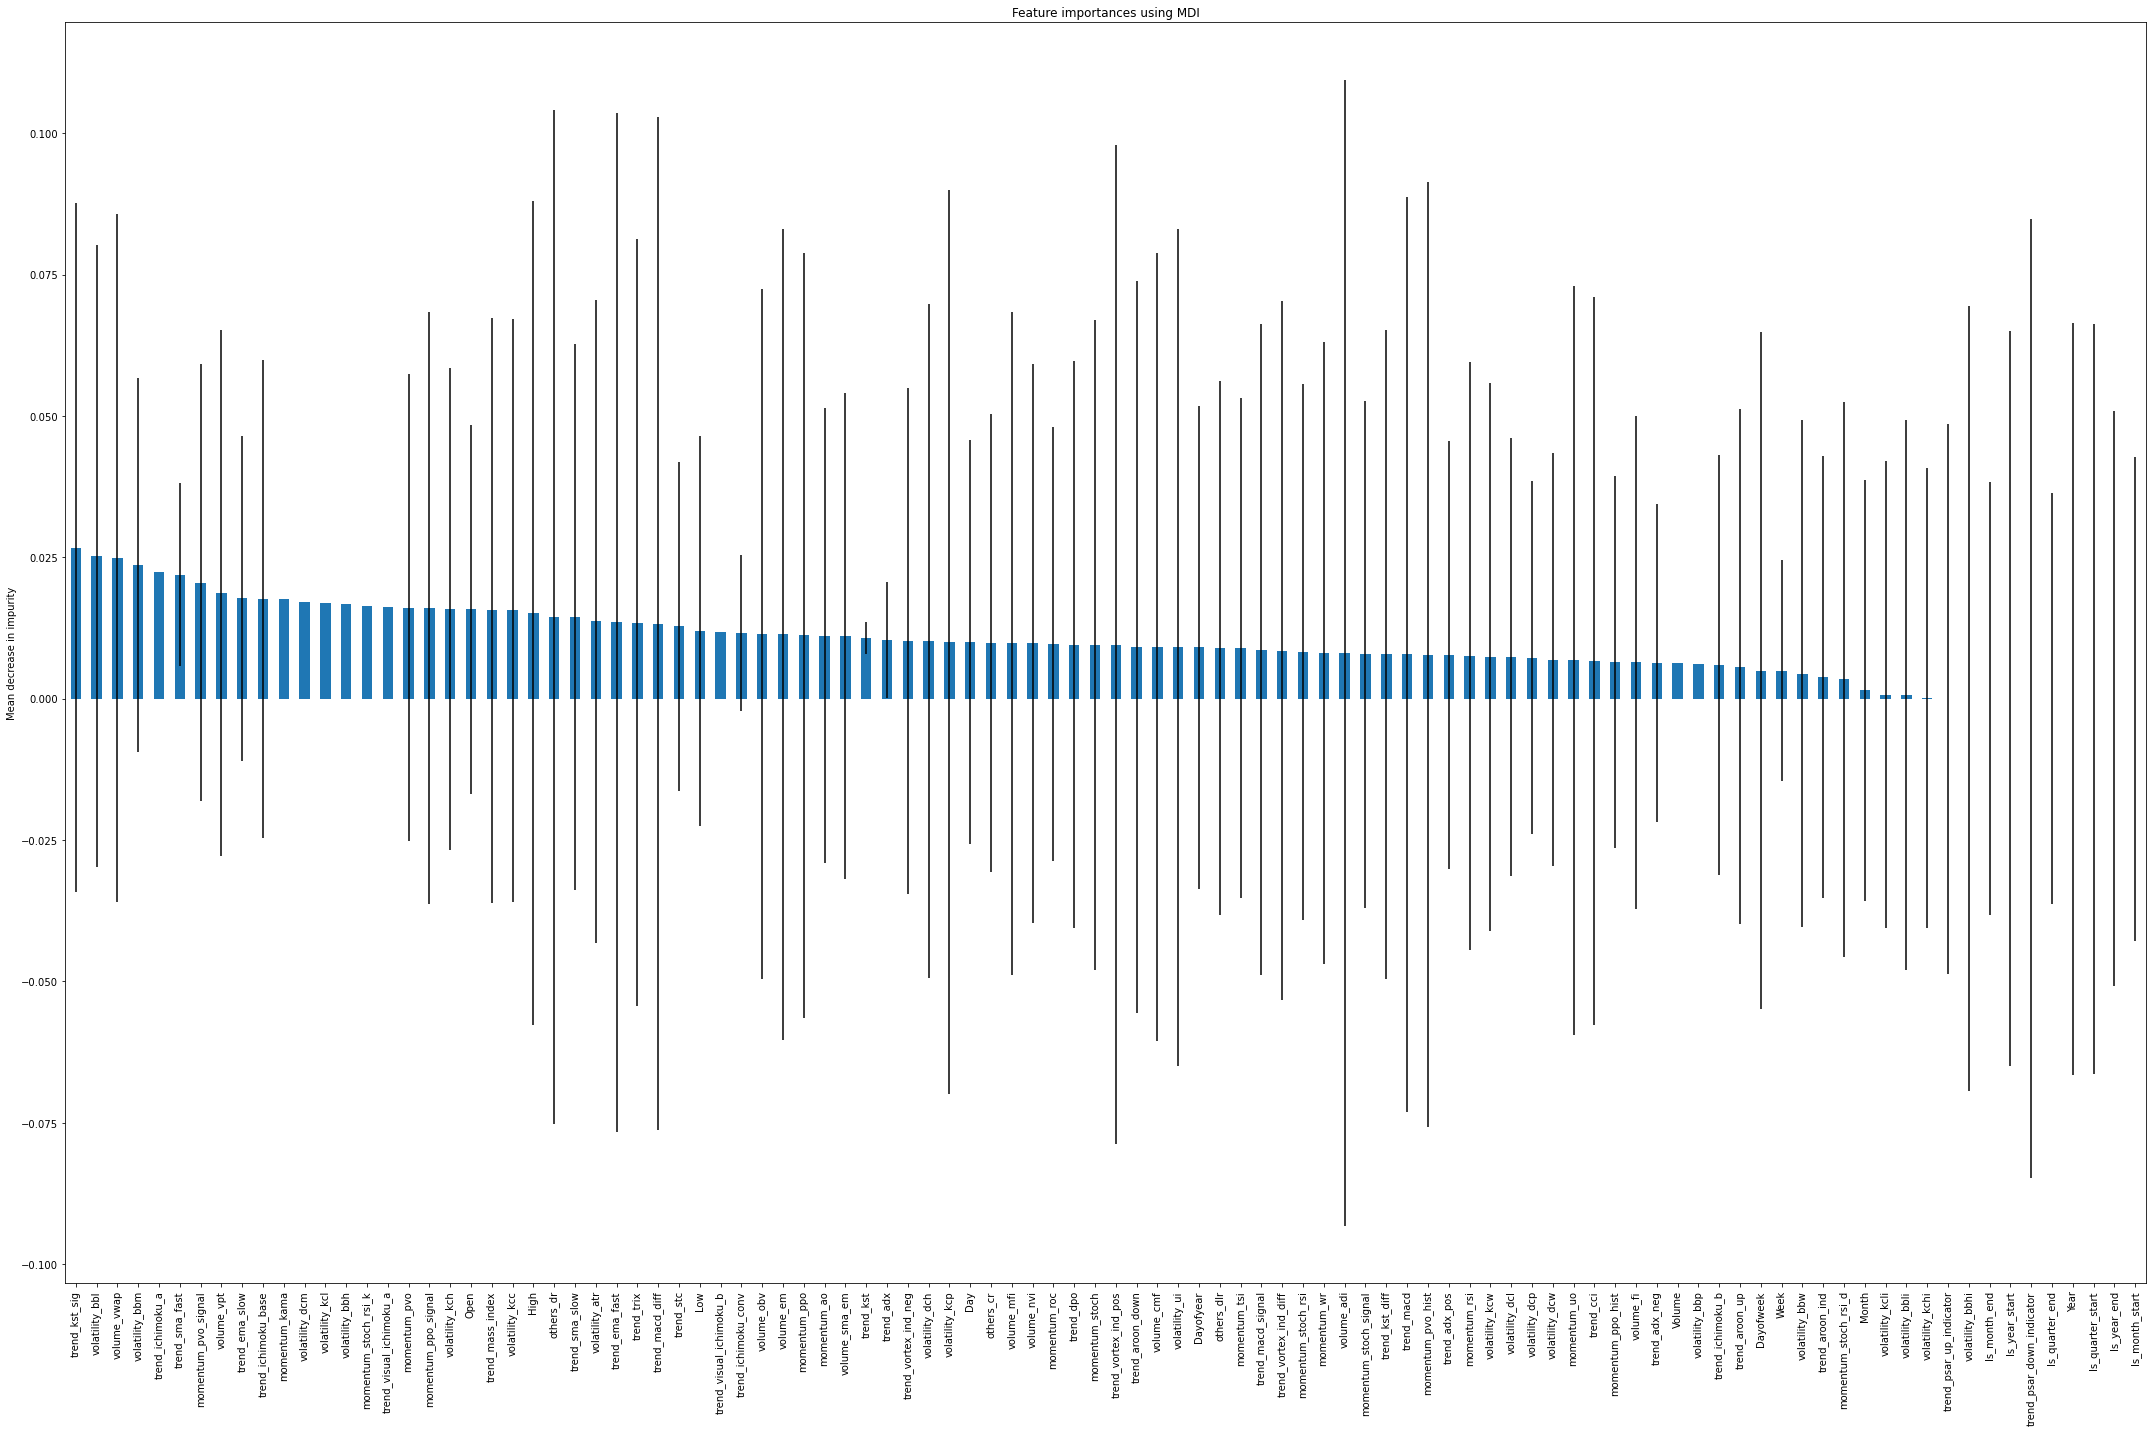

In [19]:
feature_names = [i for i in X_pandas.columns]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(30,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [20]:
forest_importances.head(20)

trend_kst_sig              0.026694
volatility_bbl             0.025203
volume_vwap                0.024929
volatility_bbm             0.023661
trend_ichimoku_a           0.022341
trend_sma_fast             0.021964
momentum_pvo_signal        0.020520
volume_vpt                 0.018710
trend_ema_slow             0.017723
trend_ichimoku_base        0.017659
momentum_kama              0.017631
volatility_dcm             0.017169
volatility_kcl             0.016891
volatility_bbh             0.016738
momentum_stoch_rsi_k       0.016459
trend_visual_ichimoku_a    0.016157
momentum_pvo               0.016085
momentum_ppo_signal        0.016054
volatility_kch             0.015813
Open                       0.015803
dtype: float64

### Part(2) Adaboost

In this part, we will implement Adaboost model. 

In [21]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_predict = ada_model.predict(X_valid)
print(metrics.classification_report(y_valid, ada_predict))

              precision    recall  f1-score   support

          -1       0.64      0.82      0.72        11
           1       0.33      0.17      0.22         6

    accuracy                           0.59        17
   macro avg       0.49      0.49      0.47        17
weighted avg       0.53      0.59      0.54        17



In [22]:
ada_accuracy = ada_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(ada_accuracy*100))
print('Improvement of {:0.2f}%.'.format( 100 * (ada_accuracy - base_accuracy) / base_accuracy))

Accuracy = 58.82%.
Improvement of 0.00%.


In [23]:
# Hyperparameter tuning : Didn't improve accuracy
# random_grid_adaboost = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
#                'algorithm': ['SAMME', 'SAMME.R'],
#                'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# ad = AdaBoostClassifier()
# ad_random = RandomizedSearchCV(estimator = ad, param_distributions = random_grid_adaboost, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)
# ad_random.fit(X_train, y_train)
# ad_best = ad_random.best_params_
# print('Parameters currently in use:\n')
# print(ad_best)
# hyper_ada_model = AdaBoostClassifier(n_estimators=ad_best['n_estimators'], learning_rate=ad_best['learning_rate'], algorithm=ad_best['algorithm'])
# hyper_ada_model.fit(X_train, y_train)
# hyper_ada_predict = hyper_ada_model.predict(X_valid)
# print(metrics.classification_report(y_valid, hyper_ada_predict))

### Part(3) Gradient Boosting

In this part, we will implement Gradient Boosting model. 

In [24]:
gra_model = GradientBoostingClassifier()
gra_model.fit(X_train, y_train)
gra_predict = gra_model.predict(X_valid)
print(metrics.classification_report(y_valid, gra_predict))

              precision    recall  f1-score   support

          -1       0.75      0.82      0.78        11
           1       0.60      0.50      0.55         6

    accuracy                           0.71        17
   macro avg       0.68      0.66      0.66        17
weighted avg       0.70      0.71      0.70        17



In [25]:
gra_accuracy = gra_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(gra_accuracy*100))
print('Improvement of {:0.2f}%.'.format( 100 * (gra_accuracy - base_accuracy) / base_accuracy))

Accuracy = 70.59%.
Improvement of 20.00%.


In [26]:
# Hyperparameter tuning : Didn't improve accuracy
# random_grid_gradient = {'n_estimators': n_estimators,
#                'max_features': max_features + ['auto'],
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# gr = GradientBoostingClassifier()
# gr_random = RandomizedSearchCV(estimator = gr, param_distributions = random_grid_gradient, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)
# gr_random.fit(X_train, y_train)
# gr_best = gr_random.best_params_
# print('Parameters currently in use:\n')
# print(gr_best)
# hyper_gra_model = GradientBoostingClassifier(n_estimators=gr_best["n_estimators"], min_samples_split=gr_best["min_samples_split"], \
#         min_samples_leaf=gr_best["min_samples_leaf"], max_features=gr_best["max_features"], max_depth=gr_best["max_depth"], \
#         learning_rate=gr_best["learning_rate"])
# hyper_gra_model.fit(X_train, y_train)
# hyper_gra_predict = hyper_gra_model.predict(X_valid)
# print(metrics.classification_report(y_valid, hyper_gra_predict))